In [3]:
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2
from qiskit.circuit import Delay

import numpy as np

import sys
import os

sys.path.append(os.path.abspath("..\\..\\..\\.."))
from metrics.IBM.get_calibration_data import get_calibration_data, get_best_qubits
from functions import *

Estudiar distribución de estados en superposición equiprobable:

-> $n$ qubits, $2^n$ estados

$$ \ket{\psi} = H^{\otimes n} \ket{0}^{\otimes n} = \ket{+}^{\otimes n} = \frac{1}{\sqrt{2^n}} \sum_{\vec{s} \in \{0;1\}^n} {\bigotimes_{i=1}^{n} {\ket{s_i}}} $$

-> matriz de densidad
$$ \rho = \bigotimes_{i=1}^{n} \ket{+}\bra{+}$$

-> matriz de densidad considerando efecto de $T_1$
$$
\rho(t) = \bigotimes_{i=1}^{n}
    \begin{bmatrix}
        1 - \frac{1}{2} e^{-t/T_1} & \alpha \\
        \alpha^* & \frac{1}{2} e^{-t/T_1}
    \end{bmatrix}
    = \bigotimes_{i=1}^{n}
    \begin{bmatrix}
        \mathbb{P}_{\ket{0}} & \alpha \\
        \alpha^* & \mathbb{P}_{\ket{1}}
    \end{bmatrix}
$$
$\alpha$ no es relevante

-> probabilidad de medir un estado con $k$ 0s y $n-k$ 1s:

$\sum_i {s_i} = n-k$

$ \mathbb{P}_{\ket{\vec{s}}} = \bra{\vec{s}} \rho(t) \ket{\vec{s}}
                    = (\mathbb{P}_{\ket{0}})^k (\mathbb{P}_{\ket{1}})^{n-k}
                    = ({1 - \frac{1}{2} e^{-t/T_1}})^k ({\frac{1}{2} e^{-t/T_1}})^{n-k} $

$$
\mathbb{P}_{\ket{\vec{s}}} = \frac{1}{2^n} ({2 - e^{-t/T_1}})^k ({e^{-t/T_1}})^{n-k}
$$

In [4]:
def prob(t, n, k, T1):
    return (2 - np.exp(-t/T1))**k * np.exp(-t*(n-k)/T1) / 2**n

def prob_T1s(t, state, T1s):
    P = 1
    for i in range(len(state)):
        T1 = T1s[i]
        if state[i] == '0':
            P *= prob(t, 1, 1, T1)
        if state[i] == '1':
            P *= prob(t, 1, 0, T1)
            
    return P


In [5]:
n = 5

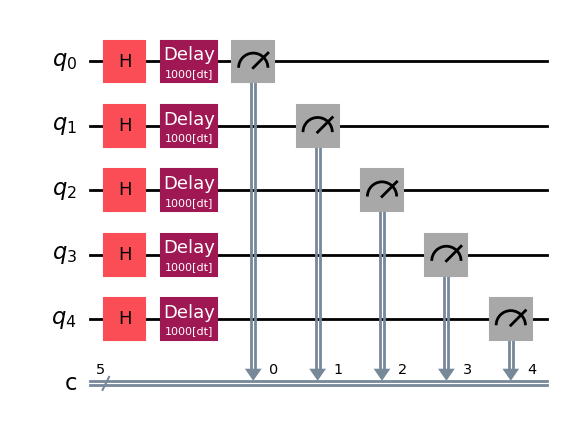

In [6]:
def load_circuit(delay, qb_len=1):
    qc = QuantumCircuit(qb_len, qb_len)

    qc.h(range(qb_len)) # superposicion total
    
    if delay > 0:
        for i in range(qb_len):
            qc.append(Delay(delay), [i])
    
    qc.measure(range(qb_len), range(qb_len))
    
    return qc

qc = load_circuit(1000, n)
qc.draw('mpl')

In [7]:
ibm_token = ""
service = QiskitRuntimeService(channel="ibm_quantum", token=ibm_token)
backend = service.backend("ibm_sherbrooke")
# data_csv = 'ibm_brisbane_calibrations_2025-01-28T20_30_11Z.csv'
data_csv = 'ibm_sherbrooke_calibrations_2025-02-24T11_37_59Z.csv'


In [8]:
# best_T1_qubits = get_best_qubits(data_csv, lambda x: x.T1, n)
data_qubits, data_edges = get_calibration_data(data_csv)

layout_qubits = [data_qubits[q] for q in [104, 124, 74, 73, 91]]
print(*[f"{q.Qubit}, T1={round(q.T1, 3)}" for q in layout_qubits], sep= '\n')

T1s = [q.T1 for q in layout_qubits]

104, T1=300.441
124, T1=302.833
74, T1=267.304
73, T1=284.893
91, T1=297.87


In [9]:
isa_circuit = transpile(qc, backend, scheduling_method="asap", optimization_level=3, initial_layout=[q.Qubit for q in layout_qubits])
print(f"Circuit Depth: {qc.depth()}")
print(f"Transpiled Circuit Depth: {isa_circuit.depth()}")

Circuit Depth: 3
Transpiled Circuit Depth: 5


In [10]:
dt = backend.configuration().dt * 10**9
print(f'dt = {round(dt, 3)} ns')

dt = 0.222 ns


In [11]:
# t_array = [t*5_000 for t in range(0, 21)] # brisbane
t_array = [t*11_250 for t in range(0, 21)] # sherbrooke
delays = [t*dt/1000 for t in t_array]
print([round(d,2) for d in delays])

[0.0, 2.5, 5.0, 7.5, 10.0, 12.5, 15.0, 17.5, 20.0, 22.5, 25.0, 27.5, 30.0, 32.5, 35.0, 37.5, 40.0, 42.5, 45.0, 47.5, 50.0]


In [12]:
# circuits = []

# for t in t_array:

#     qc = load_circuit(t, qb_len=n)

#     isa_circuit = get_transpile(qc, backend, iterations=1,
#                                 initial_layout=[q.Qubit for q in layout_qubits]
#                                 )
#     circuits.append(isa_circuit)

#     print(f"Circuit Depth: {circuits[-1].depth()}")
#     print(f"Delay Duration: {round(t*dt * 10**(-3), 3)} μs")
#     print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs")
#     print(get_layout(isa_circuit, qb_len=n), '\n')
#     # c.draw(output='mpl')

In [13]:
sampler = SamplerV2(backend=backend)
shots = 3200
# job = sampler.run(circuits, shots=shots)
# job = service.job('cycnn4c9b62g008jcem0') # shots = 1000, t_array = [t*5_000 for t in range(0, 21)], n=5
job = service.job('cyxyv14jj6dg008gmmtg') # sherbrooke, shots = 3200, t_array = [t*11_250 for t in range(0, 21)]
pub_result = job.result()


In [14]:

results = extract_results_IBM(pub_result, type='percentage', reverse_order=True)['c']


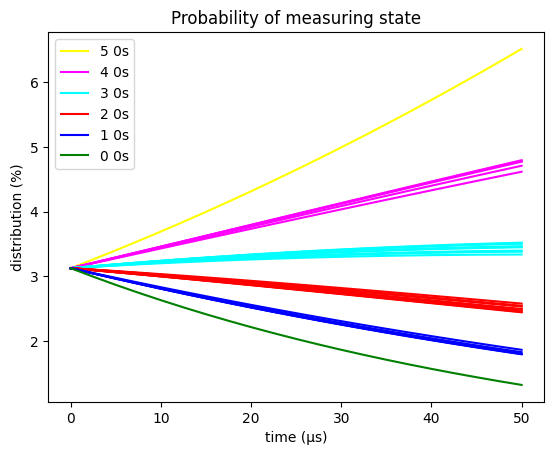

In [15]:
states = [bin(i)[2:].zfill(n) for i in range(2**n)]

import matplotlib.pyplot as plt
import math

x = delays
# + [d+50 for d in delays[1:]] + [d+100 for d in delays[1:]]

y_s = {}

for k in range(n+1)[::-1]:

    label=f"{k} 0s"

    for s in [s for s in states if np.sum([int(s_i) for s_i in s]) == n-k]:

        y_s[s] = [100 * prob_T1s(t, s, T1s) for t in x]

        plt.plot(x, y_s[s], alpha=1, color=plotting_colors[k], label=label)
        if label:
            label = None

# Add labels and title
plt.xlabel('time (μs)')
plt.ylabel('distribution (%)')
plt.title('Probability of measuring state')
plt.legend()

# Display the plot
plt.show()

In [16]:

res = {}

for k in range(n+1)[::-1]:
    
    res[k] = [np.mean([r[s] for s in r if np.sum([int(s_i) for s_i in s]) == n-k]) for r in results]


In [17]:
# from scipy.optimize import curve_fit

# t_data = np.array(x)

# T1s_estimated = []

# for k in range(n+1)[::-1]:

#     y_data = np.array(res[k])  # Valores de y

#     def model(t, T1):
#         return 100*prob(t, n, k, T1)

#     # Ajustar la curva a los datos
#     params, covariance = curve_fit(model, t_data, y_data, p0=[290])

#     # Parámetros ajustados
#     T1_estimated = params[0]
#     print(f"Parámetro T1 estimado: {round(T1_estimated,2)} μs")
#     T1s_estimated.append(T1_estimated)
#     # print(f"T1 promedio: {round(np.mean(T1s),2)} μs")

#     y_results = [model(t, T1_estimated) for t in t_data]
#     # y_results = [prob(t, n, k, 300) for t in t_data]

#     # plt.plot(t_data, y_data, 'b.')
#     # plt.plot(t_data, y_results, 'r-', label='fit: \nT1=%5.2fμs' % (T1_estimated))
#     # plt.xlabel('time (μs)')
#     # plt.ylabel('fidelity (%)')
#     # plt.title(f'states with {k} 0s')
#     # plt.legend()

#     # # Display the plot
#     # plt.show()

# T1_mean_estimated = np.mean(T1s_estimated)
# print('---------------------------------------------')
# print(f"Promedio general: {round(T1_mean_estimated,2)} μs")
# print(f"Promedio real: {round(np.mean(T1s),2)} μs")

TVD

In [18]:
alpha = generate_uniform_distribution(qb_len=n, valid_states=states)


In [19]:
tvd = [calculate_tvd(r, alpha, percentage=True) for r in results]


In [20]:
print(f"best TVD: {np.min(tvd)*100}%")

best TVD: 4.28125%


TVD ajustado a efecto de T1 segun IBM calibration data

In [21]:
alphas_T1 = []

for t in x:
    a = {}
    for s in states:
        a[s] = prob_T1s(t, s, T1s)
    alphas_T1.append(a)

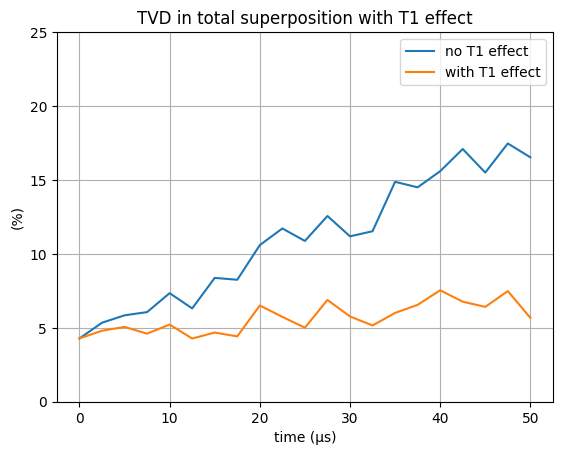

In [22]:

tvd_t1 = [calculate_tvd(results[i], alphas_T1[i], percentage=True) for i in range(len(x))]

plt.plot(x, np.array(tvd)*100, label='no T1 effect')
plt.plot(x, np.array(tvd_t1)*100, label='with T1 effect')

# plt.fill_between(x,
#                      [t*100+10 for t in tvd],
#                      [max(t*100-10,0) for t in tvd],
#                      color='blue', alpha=0.2, label=f'±ε')
# plt.fill_between(x,
#                      [t*100+10 for t in tvd_t1],
#                      [max(t*100-10,0) for t in tvd_t1],
#                      color='orange', alpha=0.2)

plt.ylim(0, 25)
plt.grid(True)
plt.xlabel('time (μs)')
plt.ylabel('(%)')
plt.title('TVD in total superposition with T1 effect')
plt.legend()

# Display the plot
plt.show()

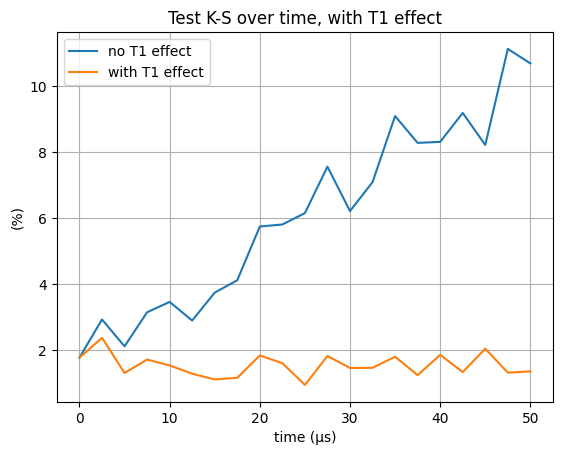

In [33]:
ks = [calculate_test_ks(results[i], alpha, percentage=True)*100 for i in range(len(x))]
ks_t1 = [calculate_test_ks(results[i], alphas_T1[i], percentage=True)*100 for i in range(len(x))]


plt.plot(x, np.array(ks), label='no T1 effect')
plt.plot(x, np.array(ks_t1), label='with T1 effect')

# plt.fill_between(x,
#                      [t*100+10 for t in tvd],
#                      [max(t*100-10,0) for t in tvd],
#                      color='blue', alpha=0.2, label=f'±ε')
# plt.fill_between(x,
#                      [t*100+10 for t in tvd_t1],
#                      [max(t*100-10,0) for t in tvd_t1],
#                      color='orange', alpha=0.2)

# plt.ylim(0, 25)
plt.grid(True)
plt.xlabel('time (μs)')
plt.ylabel('(%)')
plt.title('Test K-S over time, with T1 effect')
plt.legend()

# Display the plot
plt.show()

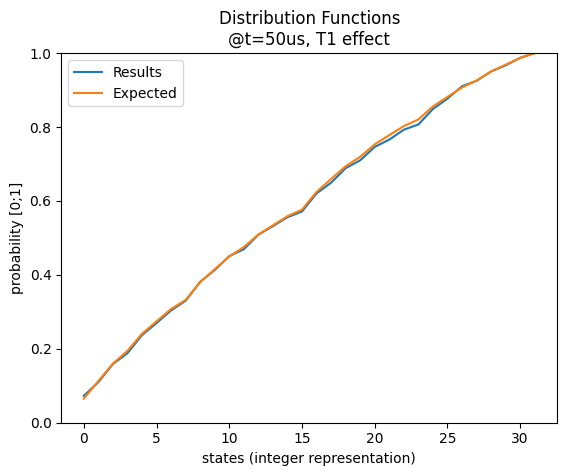

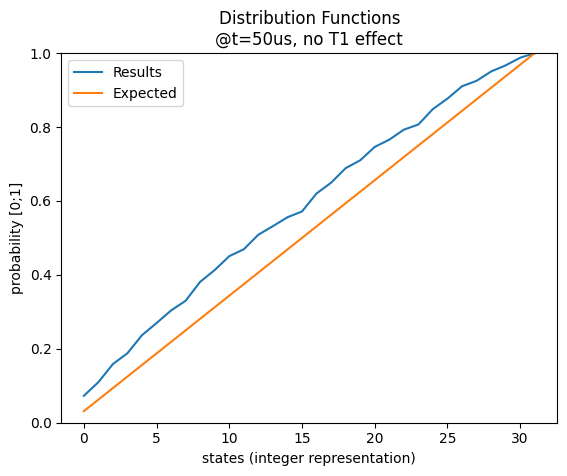

In [24]:
# for i in range(len(x)):
plot_distribution_functions(results[-1], alphas_T1[-1], title='Distribution Functions\n@t=50us, T1 effect')
plot_distribution_functions(results[-1], alpha, title='Distribution Functions\n@t=50us, no T1 effect')

In [25]:
# y = ax + b
y = [t*100 for t in tvd_t1]
m = len(x)
a = (np.mean([x[i]*y[i] for i in range(m)]) - np.mean(x)*np.mean(y)) / (np.mean([x[i]**2 for i in range(m)]) - np.mean(x)**2)
b = np.mean(y) - a*np.mean(x)

print(a)
print(b)

0.050157769495027184
4.405326062093436


In [26]:
print(*[f"({x[i]}, {round(100 - (a*x[i]+b), 2)})" for i in range(len(x))], sep='\n')

(0.0, 95.59)
(2.5, 95.47)
(5.0, 95.34)
(7.5, 95.22)
(10.0, 95.09)
(12.5, 94.97)
(15.0, 94.84)
(17.5, 94.72)
(20.0, 94.59)
(22.5, 94.47)
(25.0, 94.34)
(27.5, 94.22)
(30.0, 94.09)
(32.5, 93.96)
(35.0, 93.84)
(37.5, 93.71)
(40.0, 93.59)
(42.5, 93.46)
(45.0, 93.34)
(47.5, 93.21)
(50.0, 93.09)


In [27]:
print(f"best TVD: {round(np.min(tvd_t1)*100,2)}%")

best TVD: 4.28%


Estudiar T1 de Qubits por separado

In [28]:
qubit_results = {}

for i in range(len(layout_qubits)):

    q = layout_qubits[i].Qubit

    qubit_results[q] = {
        '0': [sum([count for state, count in r.items() if state[i] == '0']) for r in results],
        '1': [sum([count for state, count in r.items() if state[i] == '1']) for r in results]
    }

$$
\begin{equation}
\begin{split}

y(t) &= \frac{1}{2} e^{-t/T_1} \\

p(t) &:= \ln{2 y(t)} = -\frac{t}{T_1} = \alpha t, \quad T_1 = -\frac{1}{\alpha} \\

\hat{p}(t_i) &= \ln{2 \hat{y}(t_i)} \\

\text{MIN} &\sum_i{\left(\alpha t_i - \hat{p}(t_i)\right)^2} \\

\stackrel{\partial{\alpha}}{\longrightarrow} \quad & 2 \sum_i{\left(\alpha t_i - \hat{p}(t_i)\right) t_i} = 0

\Rightarrow \hat{\alpha} = \frac{ \sum_i{t_i \hat{p}(t_i)} }{ \sum_i{{t_i}^2} }

\Rightarrow \hat{T_1} = - \frac{ \sum_i{{t_i}^2} }{ \sum_i{t_i \hat{p}(t_i)} } \\

\hat{\sigma} &= \sqrt{\frac{1}{n} \sum_{i=1}^n{{\left( -\frac{t_i}{\hat{T}_1} - \hat{p}(t_i) \right)}^2}} \\

y(t) &= \frac{1}{2} e^{-\frac{t}{\hat{T}_1} \pm \hat{\sigma}}

\end{split}
\end{equation}




$$


In [29]:
qubit_T1_estimated = {}

for q in layout_qubits:
    
    y = qubit_results[q.Qubit]['1']

    # p(t) = ln(2*y(t))
    p = [np.log(2*y_i/100) for y_i in y]

    T1 = - np.sum([x_i**2 for x_i in x]) / np.sum([x[i]*p[i] for i in range(len(x))])

    # std = np.sqrt(1/len(x) * np.sum([(np.exp(-x[i]/T1)/2 - y[i]/100)**2 for i in range(len(x))]))
    std = np.sqrt(1/len(x) * np.sum([(-x[i]/T1 - p[i])**2 for i in range(len(x))]))
    # arreglar
                     
    qubit_T1_estimated[q.Qubit] = T1, std


In [30]:
def estimated_T1_bound(q, t, b, s=1):
    T1, std = qubit_T1_estimated[q.Qubit]
    match b:
        case 'upper':
            return np.exp(-t/T1 + s*std)/2*100
        case 'lower':
            return np.exp(-t/T1 - s*std)/2*100



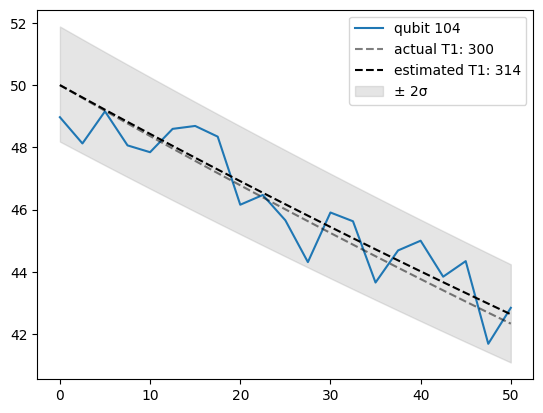

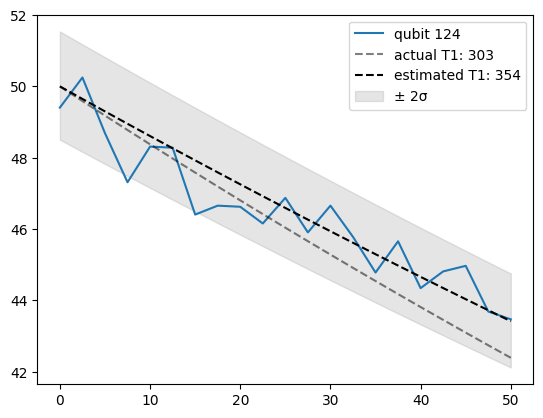

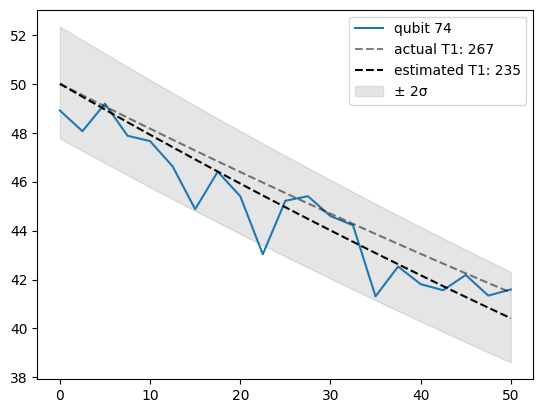

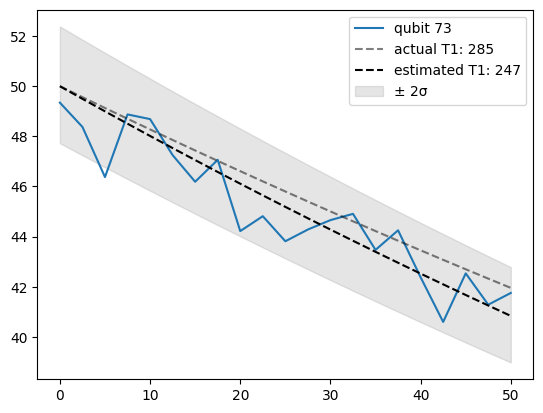

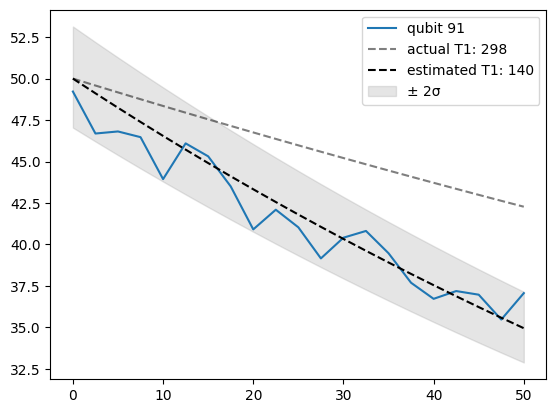

In [31]:

for q in layout_qubits:
    # color = plotting_colors[q.Qubit%len(plotting_colors)]
    plt.plot(x, qubit_results[q.Qubit]["1"], label=f"qubit {q.Qubit}")
    plt.plot(x, [np.exp(-t/q.T1)/2*100 for t in x], 'k--', alpha=0.5, label=f"actual T1: {round(q.T1)}")
    plt.plot(x, [np.exp(-t/qubit_T1_estimated[q.Qubit][0])/2*100 for t in x], 'k--', alpha=1, label=f"estimated T1: {round(qubit_T1_estimated[q.Qubit][0])}")
    conf = 2
    plt.fill_between(x,
                     [estimated_T1_bound(q, t, 'upper', s=conf) for t in x],
                     [estimated_T1_bound(q, t, 'lower', s=conf) for t in x],
                     color='gray', alpha=0.2, label=f'± {conf}σ')

    # plt.ylim(0, 50)
    plt.legend()
    plt.show()

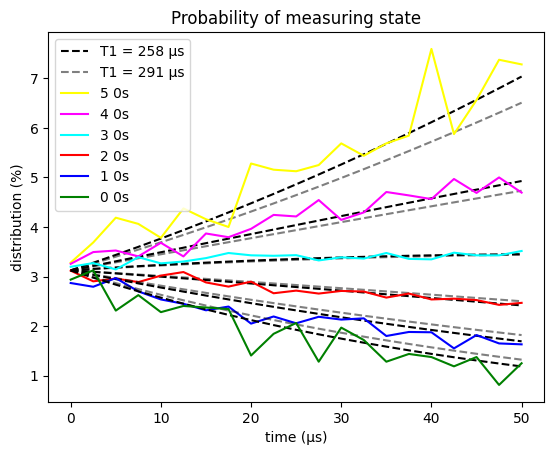

In [32]:


mean_est_T1 = np.mean([qubit_T1_estimated[q.Qubit][0] for q in layout_qubits])

for k in range(n+1)[::-1]:

    y_k = [100 * prob(t, n, k, mean_est_T1) for t in x]

    expected_y_k = [100 * prob(t, n, k, np.mean(T1s)) for t in x]
    
    if k == n:
        show_label = [f"T1 = {round(mean_est_T1)} μs", f"T1 = {round(np.mean(T1s))} μs"]
    else:
        show_label = [None, None]
    
    plt.plot(x, y_k, 'k--', label=show_label[0])
    plt.plot(x, expected_y_k, 'k--', label=show_label[1], alpha=0.5)
    plt.plot(x, res[k], plotting_colors[k], label=f"{k} 0s")

# Add labels and title
plt.xlabel('time (μs)')
plt.ylabel('distribution (%)')
plt.title('Probability of measuring state')
plt.legend()

# Display the plot
plt.show()